# FIRST NOTEBOOK - CONTENT-BASED RECOMMENDATION SYSTEM

# Importing the libraries
In this part, we are importing the libraries we need.

In [53]:
# Importing files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import sys
import glob
import datetime
import calendar
import csv

# Spark imports
from pyspark.rdd import RDD
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
from pyspark.sql.functions import col, asc, desc, split
from pyspark.sql.functions import monotonically_increasing_id

# used to check if the array has a value
from pyspark.sql.functions import array_contains

# used for the encoding of categories
from sklearn.preprocessing import MultiLabelBinarizer

# used for cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity

# Used for the indexes in content-based part
from pyspark.sql.window import Window

# Spark 
In this project, we are using apache spark as well as Pandas.

In [2]:
# Initialize a spark session.
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

In [3]:
spark = init_spark() # Initializate spark

# Buisiness dataset 
The first dataset is buisiness dataset. We are importing the dataset to work with the features and extract user and profile items.

File size: 116.078 KB

In [4]:
# Loading the business.json in spark 
path = 'data/yelp_academic_dataset_business.json'
df_business = spark.read.json(path)

In [20]:
# Print informations about the business dataset
df_business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

## Filtering restaurant businesses
Now we want to filter the Restaurant category from the dataset

In [21]:
df_business_filtered = df_business.filter(df_business.categories.contains('Restaurants'))  # Filter only restaurants

In [22]:
# Checking if there are null values
print('Number of null values in categories:',
      df_business_filtered.filter(df_business_filtered.categories.isNull()).count())

Number of null values in categories: 0


In [23]:
from pyspark.sql.functions import regexp_replace, col, lower
# Before fixing
print('Before fixing:')
df_business_filtered.select('categories').show(5, truncate=False)  # Before fixing
df_business_filtered = df_business_filtered.withColumn('categories', regexp_replace(col('categories'), " ", ""))  # Remove spaces
# After fixing
print('After fixing:')
df_business_filtered = df_business_filtered.withColumn('categories', lower(col('categories')))  # Convert to lower letters
df_business_filtered.select('categories').show(5, truncate=False)  # After fixing

Before fixing:
+----------------------------------------------------------------------------+
|categories                                                                  |
+----------------------------------------------------------------------------+
|Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries                       |
|Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants|
|Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek  |
|Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food            |
|Vietnamese, Food, Restaurants, Food Trucks                                  |
+----------------------------------------------------------------------------+
only showing top 5 rows

After fixing:
+-------------------------------------------------------------------+
|categories                                                         |
+-------------------------------------------------------------------+
|restaurants,food,bubblet

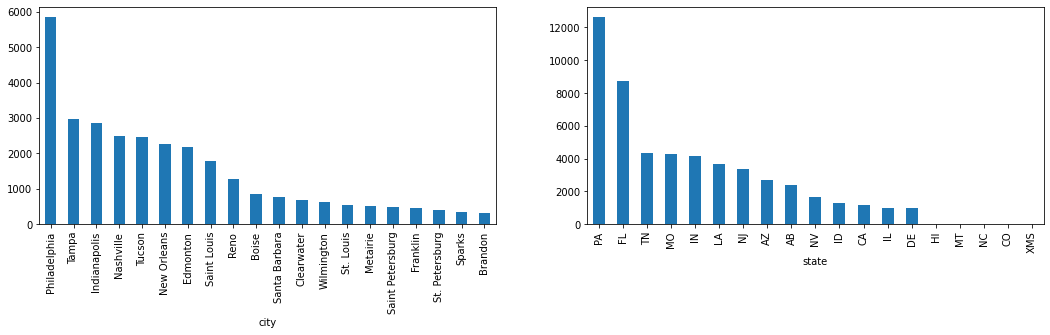

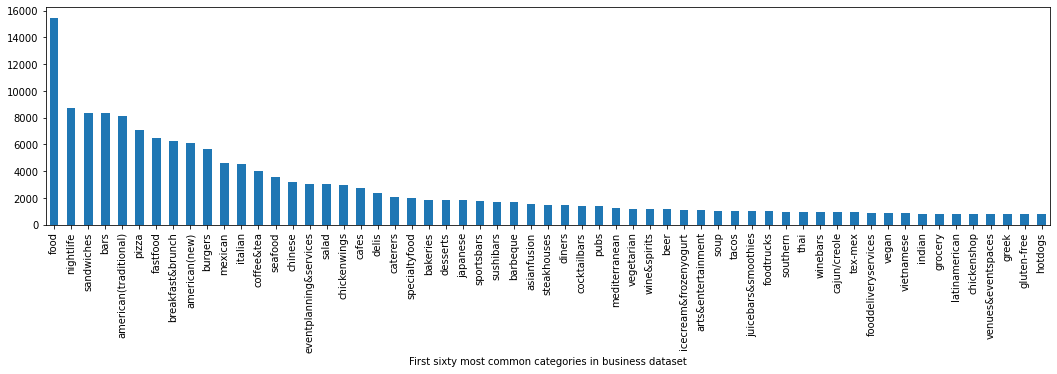

In [82]:
# Some interesting plot to know the data

df_business_pd = df_business_filtered.toPandas()

fig = plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
df_bus_count1 = df_business_pd.groupby('city').count()
df_bus_city = df_bus_count1['name']
df_bus_city_sorted = df_bus_city.sort_values(ascending = False)
df_bus_city_sorted[:20].plot(kind = 'bar')

plt.subplot(1, 2, 2)
df_bus_count2 = df_business_pd.groupby('state').count()
df_bus_state = df_bus_count2['name']
df_bus_state_sorted = df_bus_state.sort_values(ascending = False)
df_bus_state_sorted[:20].plot(kind = 'bar')


fig = plt.figure(figsize=(18, 4))
uniq_cat_dict = {}
for i in df_business_pd.categories:
    cat = str(i).replace(" ", "").split(',')
    for j in cat:
        if j not in uniq_cat_dict.keys():
            uniq_cat_dict[j] = 1
        else:
            uniq_cat_dict[j] += 1
uniq_cat_series = pd.Series(uniq_cat_dict)
uniq_cat_series.sort_values(ascending = False, inplace = True)
uniq_cat_series[1:60].plot(kind = 'bar') # Not printing the category restaurant
plt.xlabel('First sixty most common categories in business dataset')

_ = plt.plot

In [25]:
# Printing the categories
uniq_cat_series

restaurants                52268
food                       15472
nightlife                   8723
sandwiches                  8366
bars                        8337
                           ...  
hometheatreinstallation        1
homeownerassociation           1
kidshairsalons                 1
calabrian                      1
gemstones&minerals             1
Length: 728, dtype: int64

## Now we want to encode the field called categories

In [26]:
mlb = MultiLabelBinarizer()

#create boolean mask matched non NaNs values
mask = df_business_pd['categories'].notnull()

#filter by boolean indexing
arr = mlb.fit_transform(df_business_pd.loc[mask, 'categories'].dropna().str.strip('[]').str.split(','))

#create DataFrame and add missing (NaN)s index values
df_categories = (pd.DataFrame(arr, index=df_business_pd.index[mask], columns=mlb.classes_)
               .reindex(df_business_pd.index, fill_value=0))

df_categories.sort_index().head(10)

,acaibowls,accessories,accountants,activelife,acupuncture,adult,adulteducation,adultentertainment,advertising,afghan,...,winebars,wineries,winetastingclasses,winetastingroom,winetours,women'sclothing,wraps,yelpevents,yoga,zoos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Preprocessing the cities: 
After the preprocessing, the number of unique cities dropped. 

In [27]:
df_business_pd = df_business_pd.sort_values(by=['city'])  # Sorting by name
print('Original unique city values:', len(df_business_pd['city'].unique()))  # Printing the unique values
df_business_pd['city'] = df_business_pd['city'].str.lower()
print('Unique city values after changing all letter to lowercase:', len(df_business_pd['city'].unique())) # Printing the unique values

Original unique city values: 920
Unique city values after changing all letter to lowercase: 859


### Encoding the city and state

In [28]:
# Encoding feature City and State features
df_city = pd.get_dummies(df_business_pd.city).sort_index()
df_state = pd.get_dummies(df_business_pd.state).sort_index()
df_city.head(10) # printing for state (example)

,abington,abington township,affton,aldan,algiers,alloway,alton,ambler,antioch,apollo beach,...,wycombe,wyncote,wyndlake condominium,wyndmoor,wynnewood,yardley,yeadon,zephyrhills,zieglerville,zionsville
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Sorting by index for better visualization
df_restData = df_business_pd[['business_id', 'latitude','longitude','stars','is_open']].sort_index()

In [30]:
# Creating the item profile with all pre-processed enconded item features
frames = [df_restData, df_categories]
df_itemProf = pd.concat(frames, axis=1)
df_itemProf.sort_index().head(10)

,business_id,latitude,longitude,stars,is_open,acaibowls,accessories,accountants,activelife,acupuncture,...,winebars,wineries,winetastingclasses,winetastingroom,winetours,women'sclothing,wraps,yelpevents,yoga,zoos
0,MTSW4McQd7CbVtyjqoe9mw,39.955505,-75.155564,4.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CF33F8-E6oudUQ46HnavjQ,36.269593,-87.058943,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,k0hlBqXX-Bt0vf1op7Jr1w,38.565165,-90.321087,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bBDDEgkFA1Otx9Lfe7BZUQ,36.208102,-86.768170,1.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,eEOYSgkmpB90uNA7lDOMRA,27.955269,-82.456320,4.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,il_Ro8jwPlHresjw9EGmBg,39.637133,-86.127217,2.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0bPLkL0QhhPO5kt1_EXmNQ,27.916116,-82.760461,4.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,MUTTqe8uqyMdBl186RmNeA,39.953949,-75.143226,4.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,ROeacJQwBeh05Rqg7F6TCg,39.943223,-75.162568,4.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,WKMJwqnfZKsAae75RMP6jA,53.546045,-113.499169,4.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [31]:
# Apply normalization technique to Column 1, Column 2 and Column 3
df_itemProf_normalized = df_itemProf.copy()

from sklearn import preprocessing
cont = 0
for col in df_itemProf_normalized.columns[1:]:
    print(col)
    min_max_scaler = preprocessing.MinMaxScaler()
    df_itemProf_normalized[[col]] = min_max_scaler.fit_transform(df_itemProf_normalized[[col]])
    if cont == 2:
        break
    cont = cont + 1

latitude
longitude
stars


In [32]:
# View normalized data
df_itemProf_normalized

,business_id,latitude,longitude,stars,is_open,acaibowls,accessories,accountants,activelife,acupuncture,...,winebars,wineries,winetastingclasses,winetastingroom,winetours,women'sclothing,wraps,yelpevents,yoga,zoos
0,MTSW4McQd7CbVtyjqoe9mw,0.474485,0.989187,0.750,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CF33F8-E6oudUQ46HnavjQ,0.333342,0.727110,0.250,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,k0hlBqXX-Bt0vf1op7Jr1w,0.421245,0.655287,0.500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bBDDEgkFA1Otx9Lfe7BZUQ,0.330987,0.733512,0.125,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,eEOYSgkmpB90uNA7lDOMRA,0.014965,0.828446,0.750,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52263,l9eLGG9ZKpLJzboZq-9LRQ,0.473342,0.985779,0.500,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52264,cM6V90ExQD6KMSU3rRB5ZA,0.614632,0.083644,0.750,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52265,WnT9NIzQgLlILjPT0kEcsQ,0.473737,0.989119,0.875,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52266,2O2K6SXPWv56amqxCECd4w,0.470682,0.983195,0.875,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Loading the 'review' dataset
The second dataset regards the (restaurant) user's reviews.

File size: 5.216.669 KB

In [33]:
# Loading the review file
path = 'data/yelp_academic_dataset_review.json'
df_review = spark.read.json(path)

In [19]:
# Print the number of rows and columns
print((df_review.count(), len(df_review.columns)))

(6990280, 9)


In [34]:
# Printing the columns' name
df_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [35]:
# Printing the features used by us in the project
df_review = df_review[['business_id','user_id','stars']]
df_review.show(10)

+--------------------+--------------------+-----+
|         business_id|             user_id|stars|
+--------------------+--------------------+-----+
|XQfwVwDr-v0ZS3_Cb...|mh_-eMZ6K5RLWhZyI...|  3.0|
|7ATYjTIgM3jUlt4UM...|OyoGAe7OKpv6SyGZT...|  5.0|
|YjUWPpI6HXG530lwP...|8g_iMtfSiwikVnbP2...|  3.0|
|kxX2SOes4o-D3ZQBk...|_7bHUi9Uuf5__HHc_...|  5.0|
|e4Vwtrqf-wpJfwesg...|bcjbaE6dDog4jkNY9...|  4.0|
|04UD14gamNjLY0IDY...|eUta8W_HdHMXPzLBB...|  1.0|
|gmjsEdUsKpj9Xxu6p...|r3zeYsv1XFBRA4dJp...|  5.0|
|LHSTtnW3YHCeUkRDG...|yfFzsLmaWF2d4Sr0U...|  5.0|
|B5XSoSG3SfvQGtKEG...|wSTuiTk-sKNdcFypr...|  3.0|
|gebiRewfieSdtt17P...|59MxRhNVhU9MYndMk...|  3.0|
+--------------------+--------------------+-----+
only showing top 10 rows



In [36]:
# Filtering REVIEWS file by only RESTAURANTS identified with the RESTAURANT in 'categories'
df_review = df_review.join(df_business_filtered[['business_id']], df_review.business_id == df_business_filtered.business_id ,"left_semi")
df_review.count()  # Print the number of reviews after filtering

4724471

In [39]:
# Creating an auxiliar df to filter only users with more than 50 reviews
df_count_reviews = df_review.groupBy("user_id").count() # Creating a df containing the number of reviews per user
df_count_reviews1 = df_count_reviews.filter(col("count") >= 50)  # Filtering only users with more than 50 reviews
df_count_reviews1.show(10, truncate=False)  # Printing the dataframe with the count values

+----------------------+-----+
|user_id               |count|
+----------------------+-----+
|IeSz60ozr1yAVIH8CX9w9w|149  |
|FlXBpK_YZxLo27jcMdII1w|489  |
|Zsdee1KEpMwjg5cqx-VWrQ|56   |
|9WuP-4jfndovEFJ4bpt5vA|62   |
|SSafXe2aUO0cXgQhEdtzrA|104  |
|4PE0tDvV9Lo8VW8kDW1SFQ|83   |
|LnFIWZM_l__4t8Qxj3pnOg|418  |
|dioXbYFdMCyE7zCK90eM3Q|133  |
|_LT9U6nhRgny5folsaTxPA|75   |
|cbY0f25GE3WLB5YUNQUgtw|74   |
+----------------------+-----+
only showing top 10 rows



In [26]:
# Transforming the count into a list plot the distributtion of 'review count'
review_count = df_count_reviews1.select('count').rdd.flatMap(lambda x: x).collect()

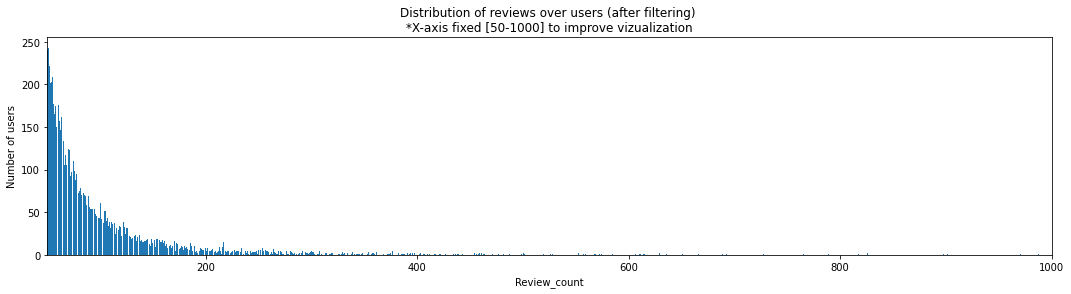

In [27]:
# Plotting the distribution
fig = plt.figure(figsize=(18, 4))
plt.hist(review_count, bins=2000)
plt.xlim([50, 1000])
plt.title('Distribution of reviews over users (after filtering) \n*X-axis fixed [50-1000] to improve vizualization')
plt.xlabel('Review_count')
plt.ylabel('Number of users')
_ = plt.plot

In [40]:
# Filtering REVIEWS by only users identified with >= 50 REVIEWS
df_review = df_review.join(df_count_reviews1, df_review.user_id == df_count_reviews1.user_id ,"left_semi")
df_review.count() # Print the number of reviews after keeping only users with >= 50 reviews

801411

In [42]:
# Printing how many Null elements we have in each categories
for i in df_review.columns:
    print(i, df_review.filter(col(i).isNull()).count())

business_id 0
user_id 0
stars 0


In [29]:
# Putting stars in a list to be used in the next plot
stars_list = [row[0] for row in df_review.select('stars').collect()]

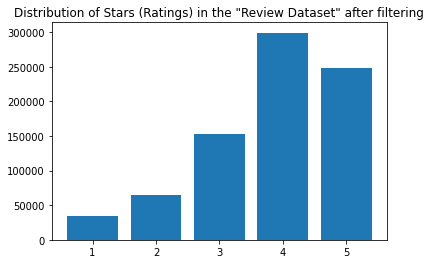

In [30]:
# Printing the distribution of STARS (RESTAURANTS RATINGS)
from collections import Counter
c = Counter(stars_list)
plt.bar(c.keys(), c.values())
plt.title('Distribution of Stars (Ratings) in the "Review Dataset" after filtering')
plt.show()

# Building and Evaluating our Content-Based Recommendation System
Here we implement and evaluate our Content-Based Recommendation System. 

For the evaluation we used the precision@k approach. Precision@k gives us the percentage of those k articles that are relevant for a given user. In other words, k items are recommended and we check among these items how many were 'relevant'.

\begin{equation}
Precision@k = \frac{Number\_of\_Relevant\_Items}{Number\_of\_Recommended\_Items}
\end{equation}

For this experiment we set k = 5 and consider as 'relevant items' restaurants with ratings >=5. 

We run the evaluation for the first 30 users of the testset. The final results is the the average value of the results for each user under evaluation.

In [43]:
def preparing_data(user_id_value, df_review, training_split):
    """
    This function prepares the data to be evaluated in our Content-Based Recommendation System. 
    It receives the whole df_review dataset, filter by a given user and divide into training and test set
    """
    df_user_f = df_review.filter(df_review.user_id == user_id_value)  # Filtering the review file just for the user
    df_user_f = df_user_f.dropDuplicates(['business_id'])  # Remove cases when user reviewed the same restaurant two times
    [train, test] = df_user_f.randomSplit([training_split, 1-training_split], seed = 0) # Splitting the dataset into train and test
    return train, test

In [44]:
def return_stars(user_id_value, train):
    """
    This function create a vector of ratings for a given user using ONLY the train set
    """
    # Creating an 'id' column to track the indices (pyspark put things in different orders for join)
    df_temp1 = df_business_filtered.select("*").withColumn("id", monotonically_increasing_id())
    
    # Finding ratings for all items for the current user. 'Null' is returned for non reted items
    df_temp1 = df_temp1[['business_id','id']].join(train, ['business_id'], how="full_outer") 

    df_temp1 = df_temp1.sort(col("id")) # Returning df to the original order
    df_stars = df_temp1.select('stars') # Getting the list of stars
    df_stars = df_stars.fillna(0, subset=['stars']) # Converting 'Null' values to '0'
    
    return df_stars

In [58]:
def build_user_profile(user_id_value, train):
    """
    This function creates the user_profile given the user and the TRAIN SET
    """
    df_stars = return_stars(user_id_value, train)  # Using the function return_stars to form a vector with all restaurants reviwed 
    np_stars = [int(row['stars']) for row in df_stars.collect()]  # Convert stars to list (for matrix operation)
    np_stars = np.array(np_stars)
    np_items_matrix1 = np.array(df_itemProf_normalized.iloc[:,1:])  # dropping business ID column from item profile df and trsansformin np.array
    user_profile = (np.matmul(np_stars.transpose(), np_items_matrix1))/np.sum(np_stars)
    return user_profile

In [46]:
def content_based_test(user_profile, k_value, test):
    """
    This function uses the user_profile and calculate the K most recommended items in the TEST SET
    """
    business_list = [row[0] for row in test.select('business_id').collect()]
    
    df_itemProf1 = df_itemProf_normalized[df_itemProf_normalized['business_id'].isin(business_list)]
    np_items_matrix1 = np.array(df_itemProf1.iloc[:,1:])  # transform to np.array and do not consider first column
    similarity = cosine_similarity(user_profile.reshape(1, -1), np_items_matrix1[:])  # find the cosine_similarity
    indices = (-similarity[0]).argsort()[:k_value] # Returning the position of the K highest similarities found for a given user
    return df_itemProf1['business_id'].to_numpy()[np.array([indices])]  # Return the list of k business_id most similar

In [47]:
def precision_at_k(array_business, test, treshold_score):
    """
    This function calculate the precision@k. Note that the treshold score defines if the item is relevant or not.
    """
    k_value = len(array_business)
    test = test[test['business_id'].isin(array_business)]
    array_score = test['stars'].to_numpy()
    precision_k = np.sum(array_score>=treshold_score)/k_value # return precision score (in %)
    return precision_k, array_score

In [48]:
def detailed_results(array_business, array_score):
    """
    This function print the detailed results
    """
    df_results = df_business_pd[df_business_pd['business_id'].isin(array_business)]
    df_results = df_results[['name', 'categories']]
    df_results['real_scores'] = array_score
    return df_results

In [ ]:
###################################################################
####################### SIMULATION ################################
###################################################################

In [49]:
# Getting the list of all users
# user_id_value = 'SSafXe2aUO0cXgQhEdtzrA'
unique_users_list = df_count_reviews1.select('user_id').rdd.flatMap(lambda x: x).collect() 

In [60]:
# Parameters of the recommender system and evaluation
training_split = 0.8  # 80% of the dataset is used to train
k_value = 5  # Recommend five most similar items
treshold_score = 5  # Items with stars 4 or ABOVE are considered RELEVANT
num_users = 30  # Number of users evaluated
historical_precision = []  # Auxiliar variable to store all precision
cont = 1

# Running the recommender system for NUM_USERS
for user_id_value in unique_users_list[0:num_users]:
    [train, test] = preparing_data(user_id_value, df_review, training_split)
    user_profile = build_user_profile(user_id_value, train)
    test1 = test.toPandas()
    array_business = content_based_test(user_profile, k_value, test)
    [precision_k, array_score] = precision_at_k(array_business[0], test1, treshold_score)
    historical_precision.append(precision_k)
    
    print('-----------------------------------------------------------------------------------------------')
    print('Test #%i: Content-Based Recommender System for user "%s"' %(cont, user_id_value))
    cont = cont + 1
    print('Achieved precision_k with %i recommendations items (considering >=%i stars as Relevant): %f' %(k_value, treshold_score, precision_k))
    print('Detailed information about the recommendation list:')
    display(detailed_results(array_business[0], array_score))
    print('\n')

print('---------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------')
print('FINAL AVERAGE RESULTS')
print('The average performance of the system in terms of precision_k is:', np.average(historical_precision))
print('---------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------------------
Test #1: Content-Based Recommender System for user "IeSz60ozr1yAVIH8CX9w9w"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.600000
Detailed information about the recommendation list:


,name,categories,real_scores
3270,Athens Restaurant,"greek,restaurants,breakfast&brunch",5.0
16980,Taste of China,"restaurants,chinese",5.0
37934,Marco's Pizza,"restaurants,pizza",4.0
47962,The Grind Coffee Bar & Cafe at Westchase,"food,coffee&tea,breakfast&brunch,cafes,restaur...",5.0
12183,First Watch,"breakfast&brunch,cafes,restaurants,american(tr...",3.0




-----------------------------------------------------------------------------------------------
Test #2: Content-Based Recommender System for user "FlXBpK_YZxLo27jcMdII1w"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_scores
35234,Carmen's Italian Restaurant & Bar,"restaurants,italian",4.0
22882,Johnny Apples Restaurant & Bar,"bars,restaurants,nightlife,american(traditional)",5.0
47814,City Line Pizza,"pizza,restaurants",4.0
47096,Perri's Pizza,"restaurants,pizza",4.0
48905,Ristorante Pesto,"restaurants,italian",4.0




-----------------------------------------------------------------------------------------------
Test #3: Content-Based Recommender System for user "Zsdee1KEpMwjg5cqx-VWrQ"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.000000
Detailed information about the recommendation list:


,name,categories,real_scores
3009,fat Rooster diner,"sandwiches,restaurants,breakfast&brunch,americ...",3.0
7006,Le Peep Restaurant,"food,breakfast&brunch,restaurants",2.0
49533,Yats,"cajun/creole,restaurants",4.0
20829,The Living Room Lounge,"american(new),karaoke,lounges,bars,nightlife,a...",4.0
51292,McDonald's,"food,restaurants,fastfood,coffee&tea,burgers",1.0




-----------------------------------------------------------------------------------------------
Test #4: Content-Based Recommender System for user "9WuP-4jfndovEFJ4bpt5vA"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_scores
26936,Terrene,"restaurants,vegetarian,american(new)",5.0
51989,Three Monkeys,"pizza,nightlife,breakfast&brunch,restaurants,b...",4.0
31452,Paddy O's,"sportsbars,nightlife,american(traditional),bar...",4.0
32093,Colombo's Cafe & Tavern,"american(traditional),restaurants",4.0
831,Trattoria Marcella,"italian,localflavor,restaurants",3.0




-----------------------------------------------------------------------------------------------
Test #5: Content-Based Recommender System for user "SSafXe2aUO0cXgQhEdtzrA"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_scores
49017,Caffé Buondí,"breakfast&brunch,restaurants",4.0
35176,Greek Tony's Pizza & Sub Shop,"pizza,restaurants",5.0
41901,Ristorante Roma,"italian,specialtyfood,bars,food,nightlife,rest...",4.0
15571,Blue Sushi Sake Grill,"sushibars,restaurants,nightlife,cocktailbars,j...",5.0
8240,J Devoti Trattoria,"winebars,american(new),restaurants,italian,bar...",4.0




-----------------------------------------------------------------------------------------------
Test #6: Content-Based Recommender System for user "4PE0tDvV9Lo8VW8kDW1SFQ"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.800000
Detailed information about the recommendation list:


,name,categories,real_scores
47340,Shiroi Hana,"japanese,restaurants,sushibars",4.0
31744,Zanzibar Blue,"american(new),restaurants",5.0
7484,T.C. Palate,"chinese,restaurants",5.0
8865,Haru,"restaurants,japanese",5.0
149,Jong Ka Jib,"korean,restaurants",5.0




-----------------------------------------------------------------------------------------------
Test #7: Content-Based Recommender System for user "LnFIWZM_l__4t8Qxj3pnOg"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.000000
Detailed information about the recommendation list:


,name,categories,real_scores
36444,Amis Trattoria,"restaurants,italian",2.0
34224,Talula's Garden,"american(new),restaurants",2.0
49898,Helm,"american(new),restaurants,food",4.0
18365,Dante & Luigi's,"italian,restaurants",4.0
13904,Little Thai Market,"thai,restaurants",4.0




-----------------------------------------------------------------------------------------------
Test #8: Content-Based Recommender System for user "dioXbYFdMCyE7zCK90eM3Q"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.000000
Detailed information about the recommendation list:


,name,categories,real_scores
40335,The Plough & the Stars,"nightlife,irish,restaurants,bars,gastropubs,pubs",4.0
37497,Dark Horse Pub,"pubs,restaurants,bars,american(traditional),ni...",3.0
3593,PrimoHoagies,"italian,sandwiches,restaurants",4.0
2348,Joe's Steaks + Soda Shop,"sandwiches,restaurants,cheesesteaks",4.0
29059,Poe's Sandwich Joint,"sandwiches,american(traditional),restaurants",4.0




-----------------------------------------------------------------------------------------------
Test #9: Content-Based Recommender System for user "_LT9U6nhRgny5folsaTxPA"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.600000
Detailed information about the recommendation list:


,name,categories,real_scores
6354,Bodega,"spanish,cafes,cuban,latinamerican,juicebars&sm...",5.0
24722,Fresco's Waterfront Bistro,"nightlife,restaurants,seafood,bistros,american...",5.0
11094,Noble Crust,"breakfast&brunch,pizza,southern,italian,nightl...",5.0
50113,La V Vietnamese Fusion,"sandwiches,juicebars&smoothies,vietnamese,asia...",1.0
17481,Green Culture,"food,specialtyfood,acaibowls,restaurants,break...",4.0




-----------------------------------------------------------------------------------------------
Test #10: Content-Based Recommender System for user "cbY0f25GE3WLB5YUNQUgtw"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_scores
13811,The Rudder At Anchor High Marina,"american(traditional),restaurants,arts&enterta...",5.0
40185,Buffalo Wild Wings,"american(traditional),bars,sportsbars,chickenw...",3.0
1920,Village Pub & Beer Garden,"american(traditional),food,american(new),bars,...",3.0
41215,Sky Blue Cafe,"american(traditional),restaurants,coffee&tea,b...",1.0
5387,Cock of the Walk,"american(traditional),restaurants",3.0




-----------------------------------------------------------------------------------------------
Test #11: Content-Based Recommender System for user "aHiQYaTXrmQTeG6106l5wg"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_scores
50916,Flavor of India,"restaurants,indian",5.0
15030,Salsa Verde Restaurant,"restaurants,mexican",3.0
17558,La Placita Cafe,"salad,restaurants,mexican,soup",4.0
32039,Arby's,"fastfood,sandwiches,restaurants",4.0
42679,CeeDee Jamaican Kitchen,"caribbean,restaurants",4.0




-----------------------------------------------------------------------------------------------
Test #12: Content-Based Recommender System for user "sIH5HbEwhbxt-4waYoDUBw"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_scores
48651,Iron Hill Brewery & Restaurant,"bars,nightlife,sportsbars,american(new),restau...",4.0
43620,Real Food Eatery,"gluten-free,breakfast&brunch,american(traditio...",4.0
7889,Cantina Dos Segundos,"nightlife,restaurants,breakfast&brunch,bars,me...",4.0
13198,Mace's Crossing,"american(traditional),restaurants,bars,nightlife",3.0
47716,J D McGillicuddys,"nightlife,sportsbars,restaurants,american(trad...",5.0




-----------------------------------------------------------------------------------------------
Test #13: Content-Based Recommender System for user "CDxlgCoUoNRV3VMkYZrUuQ"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.000000
Detailed information about the recommendation list:


,name,categories,real_scores
34224,Talula's Garden,"american(new),restaurants",3.0
21382,England Pizza,"pizza,restaurants",2.0
5812,Prince Pizza II,"restaurants,pizza",4.0
11273,Macaroni's Restaurant,"restaurants,nightlife,beergardens,italian,pizza",3.0
16721,NYPD Pizza,"pizza,restaurants",3.0




-----------------------------------------------------------------------------------------------
Test #14: Content-Based Recommender System for user "7vt29eIGszODjavXK-B42Q"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_scores
15995,Bonefish Grill,"seafood,bars,restaurants,american(new),cocktai...",4.0
1123,Slim Goodies Diner,"diners,cajun/creole,breakfast&brunch,american(...",5.0
20013,Wendy's,"burgers,fastfood,restaurants",4.0
41054,Fat Harry's,"cajun/creole,burgers,bars,restaurants,nightlif...",2.0
9864,Dry Dock Cafe,"american(traditional),bars,nightlife,restauran...",3.0




-----------------------------------------------------------------------------------------------
Test #15: Content-Based Recommender System for user "7NyerV7a3CsvYC20iSfLHg"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.000000
Detailed information about the recommendation list:


,name,categories,real_scores
36271,Herosame,"restaurants,japanese",3.0
9329,Hope's Cookies,"bakeries,restaurants,food",2.0
10952,Blackfish,"restaurants,american(new)",4.0
32341,Le Virtu,"italian,restaurants",3.0
6717,At The Table BYOB,"restaurants,french,american(traditional),ameri...",2.0




-----------------------------------------------------------------------------------------------
Test #16: Content-Based Recommender System for user "Zsucq1c-sjuGxs5jZuUEEg"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.600000
Detailed information about the recommendation list:


,name,categories,real_scores
41951,The Pint Public House,"nightlife,bars,restaurants,pubs",5.0
21205,Blue Orchid Chinese Restaurant,"panasian,chinese,restaurants",5.0
13418,Japonais Bistro,"sushibars,japanese,restaurants",3.0
33163,Khazana Restaurant,"pakistani,restaurants,indian",5.0
16245,The Happy Camel,"bakeries,restaurants,food,delis",4.0




-----------------------------------------------------------------------------------------------
Test #17: Content-Based Recommender System for user "417svAEVHreK6c3SK4M8Tw"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_scores
22134,Shade Restaurant & Bar,"barbeque,restaurants",4.0
9014,King Edwards Chicken,"american(new),restaurants",4.0
4076,Wagon Wheel Pizza,"restaurants,pizza",3.0
35710,Hacienda Mexican Restaurant,"restaurants,mexican",3.0
41850,Prasino,"restaurants,american(new),bars,nightlife",5.0




-----------------------------------------------------------------------------------------------
Test #18: Content-Based Recommender System for user "N-011DC3U_yyX_oTvC03Vw"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.600000
Detailed information about the recommendation list:


,name,categories,real_scores
35937,Five Points Pizza,"nightlife,bars,italian,restaurants,pizza,food",4.0
31021,Lockeland Table,"american(traditional),restaurants,american(new)",5.0
41215,Sky Blue Cafe,"american(traditional),restaurants,coffee&tea,b...",5.0
48960,Cafe Roze,"american(new),restaurants,bars,nightlife,break...",4.0
21023,Tower Market and Deli,"restaurants,delis",5.0




-----------------------------------------------------------------------------------------------
Test #19: Content-Based Recommender System for user "wZWB41wmnv4pPsetuIN5Gw"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.000000
Detailed information about the recommendation list:


,name,categories,real_scores
21456,Mistral KOP,"american(new),desserts,food,restaurants,sandwi...",4.0
45746,Barcelona Wine Bar Passyunk,"nightlife,bars,restaurants,winebars,tapas/smal...",4.0
17397,Front Street Cafe,"coffee&tea,restaurants,cafes,american(new),coc...",4.0
18926,Govinda's Vegetarian,"vegan,cheesesteaks,restaurants,vegetarian,sand...",4.0
25617,Zama,"sushibars,japanese,restaurants",2.0




-----------------------------------------------------------------------------------------------
Test #20: Content-Based Recommender System for user "rM_xdipcViCdgDPb3uKLwQ"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.000000
Detailed information about the recommendation list:


,name,categories,real_scores
36461,Dave & Buster's,"restaurants,american(traditional),eatertainmen...",1.0
45744,Carl's Delicatessen Restaurant,"delis,restaurants",4.0
39284,Bandana's Bar-B-Q,"eventplanning&services,caterers,restaurants,ba...",3.0
37104,Cardwell's At the Plaza,"restaurants,american(new)",3.0
1309,Crown Candy Kitchen,"specialtyfood,food,american(traditional),diner...",4.0




-----------------------------------------------------------------------------------------------
Test #21: Content-Based Recommender System for user "CdCUg3pTo0CivKbD8-Ysdg"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_scores
45155,Oak Oven,"italian,restaurants,pizza",5.0
11883,R & O Restaurant,"sandwiches,restaurants,pizza,cajun/creole",3.0
29496,Cote Sud,"pizza,restaurants,french",5.0
39637,Ba Chi Canteen,"restaurants,vietnamese",4.0
24392,Toby's Original Little Italy Pizza,"italian,pizza,restaurants",4.0




-----------------------------------------------------------------------------------------------
Test #22: Content-Based Recommender System for user "P-IOj5pH_cy-HnAVk4wlDA"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_scores
3362,Ginza Restaurant,"japanese,sushibars,restaurants",4.0
48527,Fusion Bowl,"vietnamese,coffee&tea,restaurants,asianfusion,...",5.0
48657,Yummy House China Bistro,"seafood,dimsum,restaurants,chinese",3.0
34628,Columbia Restaurant,"latinamerican,restaurants,spanish,american(tra...",4.0
15003,Cafe Perera,"cafes,breakfast&brunch,restaurants",5.0




-----------------------------------------------------------------------------------------------
Test #23: Content-Based Recommender System for user "pV-zk27LoaY3sQiSr9kImg"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.000000
Detailed information about the recommendation list:


,name,categories,real_scores
10463,JerryBobs Restaurant,"sandwiches,breakfast&brunch,restaurants,burgers",2.0
10806,Panda House,"chinese,restaurants",2.0
44078,Rigoberto's Mexican Food,"mexican,restaurants",2.0
30866,Agave,"restaurants,american(traditional),american(new...",2.0
42679,CeeDee Jamaican Kitchen,"caribbean,restaurants",3.0




-----------------------------------------------------------------------------------------------
Test #24: Content-Based Recommender System for user "zgOp2LnpN1d1ETzssrypww"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_scores
6599,Don Jose's Grill,"restaurants,mexican",5.0
38162,Pho Orchid,"vietnamese,restaurants",4.0
29496,Cote Sud,"pizza,restaurants,french",4.0
7269,Jacques-Imo's Cafe,"seafood,cajun/creole,restaurants,vegetarian",3.0
22689,Fogo de Chão Brazilian Steakhouse,"steakhouses,restaurants,brazilian,seafood",3.0




-----------------------------------------------------------------------------------------------
Test #25: Content-Based Recommender System for user "ZVJvlDWkmxtIsxISJgNuvQ"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_scores
35084,La Fontana Della Citta,"italian,food,restaurants",3.0
33694,Ho Sai Gai Restaurant,"chinese,restaurants",2.0
18365,Dante & Luigi's,"italian,restaurants",5.0
1890,Jamaican Jerk Hut,"caribbean,restaurants",1.0
24013,Serpico,"restaurants,american(new)",4.0




-----------------------------------------------------------------------------------------------
Test #26: Content-Based Recommender System for user "UvGrtngH9e8MFhaWznAXww"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_scores
28449,Tiramisu,"italian,restaurants",4.0
36444,Amis Trattoria,"restaurants,italian",3.0
26648,Taco Maya,"restaurants,mexican,food",4.0
2210,Thai Place Restaurant,"thai,restaurants",5.0
31431,Shorty's Sunflower Cafe,"restaurants,food,cafes",5.0




-----------------------------------------------------------------------------------------------
Test #27: Content-Based Recommender System for user "S-gn07vdS1TqsJXWEDPbng"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_scores
20242,Buffalo Wild Wings,"chickenwings,restaurants,nightlife,sportsbars,...",3.0
39095,Sal's Famous Pizzeria,"italian,restaurants,pizza",2.0
1793,Biscuits Cafe,"restaurants,mexican,breakfast&brunch",5.0
49065,The AVG Pub,"nightlife,sportsbars,american(traditional),res...",4.0
51917,Kuma's Corner,"burgers,beergardens,american(traditional),rest...",5.0




-----------------------------------------------------------------------------------------------
Test #28: Content-Based Recommender System for user "am7-gkH_PDz598oTdYSD6A"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.000000
Detailed information about the recommendation list:


,name,categories,real_scores
21611,Crab Joyous,"seafood,restaurants",3.0
10545,Bridget Foy's,"breakfast&brunch,nightlife,bars,american(tradi...",4.0
8051,Shee Yuan Chinese,"chinese,restaurants",3.0
666,Han Dynasty,"restaurants,chinese,szechuan",4.0
28339,Green Leaf Restaurant,"restaurants,breakfast&brunch,american(traditio...",3.0




-----------------------------------------------------------------------------------------------
Test #29: Content-Based Recommender System for user "O9Dbdo2LZut3e8VqIY9gtg"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_scores
43921,Shaker & Peel,"mexican,tacos,restaurants,cocktailbars,food,sa...",5.0
3173,Berlins Doener,"restaurants,kebab,german",4.0
2897,Ted Peter's Famous Smoked Fish,"seafood,burgers,restaurants",3.0
50917,The Pesky Pelican Brew Pub,"burgers,nightlife,american(traditional),sports...",5.0
10072,Shells Seafood - St Pete Beach,"breakfast&brunch,seafood,sandwiches,restaurants",4.0




-----------------------------------------------------------------------------------------------
Test #30: Content-Based Recommender System for user "3j50d_OtZ5gCTW4uZIFw9Q"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_scores
16652,Three Kings Public House,"restaurants,gastropubs,bars,pubs,nightlife,ame...",5.0
16036,Bartolino's South,"italian,restaurants",4.0
14700,McGurk's,"pubs,bars,american(traditional),restaurants,ir...",4.0
3682,Blackthorn Pub and Pizza,"pizza,pubs,bars,nightlife,restaurants",3.0
24701,Dulany's Grille and Pub,"nightlife,italian,restaurants,bars,pubs,americ...",5.0




---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
FINAL AVERAGE RESULTS
The average performance of the system in terms of precision_k is: 0.26000000000000006
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------


# Baseline Algorithm (Item Average Rating Recommender)
In order to set a baseline, in this part we introduce a baseline algorithm that recommends items (restaurants) based on the Item Average Rating. We use the same testset to evaluate and the same precision@k.

For this experiment we set k = 5 and consider as 'relevant items' restaurants with ratings >=5. 

We run the evaluation for the first 30 users of the testset. The final results is the the average value of the results for each user under evaluation (same conditions as in Content-Based Recommendation System).

In [201]:
df_review_pd = df_review.toPandas()  # converting to pandas
df_business_filtered_pd = df_business_filtered.toPandas()  # converting to pandas

In [210]:
# Parameters of the recommender system and evaluation
training_split = 0.8  # 80% of the dataset is used to train
k_value = 5  # Recommend five most similar items
treshold_score = 5  # Items with stars 4 or ABOVE are considered RELEVANT
num_users = 30  # Number of users evaluated
historical_precision = []  # Auxiliar variable to store all precision
cont = 1

# Running the recommender system for NUM_USERS
for user in unique_users_list[0:num_users]:
    [train, test] = preparing_data(user, df_review, training_split)
    test_pd = test.toPandas()
    df_matrix = pd.merge(test_pd, items_avg, on='business_id')
    df_matrix = df_matrix.sort_values(by=['item_avg'], ascending=False)
    
    k_pred_stars = df_matrix['item_avg'].to_numpy()[0:k_value]
    k_real_stars = df_matrix['stars'].to_numpy()[0:k_value]
    
    precision_k = np.sum(k_real_stars>=treshold_score)/k_value # return precision score (in %)
    historical_precision.append(precision_k)
    
    df_matrix = pd.merge(df_matrix, df_business_filtered_pd[['business_id','name','categories']], on='business_id')
    df_matrix = df_matrix.drop(['business_id','user_id'], axis = 1)
    df_matrix = df_matrix[['name','categories','stars','item_avg']]
    df_matrix.rename(columns={'stars': 'real_score'}, inplace=True)
    
    print('-----------------------------------------------------------------------------------------------')
    print('Test #%i: Content-Based Recommender System for user "%s"' %(cont, user))
    cont = cont + 1
    print('Achieved precision_k with %i recommendations items (considering >=%i stars as Relevant): %f' %(k_value, treshold_score, precision_k))
    print('Detailed information about the recommendation list:')
    display(df_matrix[0:k_value])
    print('\n')

print('---------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------')
print('FINAL AVERAGE RESULTS')
print('The average performance of the system in terms of precision_k is:', np.average(historical_precision))
print('---------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------------------
Test #1: Content-Based Recommender System for user "IeSz60ozr1yAVIH8CX9w9w"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Sucre Table,"bakeries,customcakes,food,restaurants",4.0,4.760000
1,Ras Rody's Jamaican Vegan Food,"food,restaurants,streetvendors,vegan,vegetarian",5.0,4.750000
2,Saigon Deli,"vietnamese,delis,soup,coffee&tea,food,restaurants",5.0,4.403614
3,First Watch,"breakfast&brunch,cafes,restaurants,american(tr...",4.0,4.138462
4,Carrabba's Italian Grill,"nightlife,bars,seafood,italian,restaurants",4.0,4.062500




-----------------------------------------------------------------------------------------------
Test #2: Content-Based Recommender System for user "FlXBpK_YZxLo27jcMdII1w"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.800000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Tony Lukes Casa De Pasta,"italian,restaurants",5.0,5.000000
1,Polka Deli Inc,"delis,restaurants,sandwiches",5.0,5.000000
2,Cibo By Illiano,"sandwiches,fooddeliveryservices,specialtyfood,...",4.0,4.666667
3,The Inn At Barley Sheaf Farm,"venues&eventspaces,eventplanning&services,amer...",5.0,4.625000
4,Trail's End Cafe At Cynwyd Station,"desserts,sandwiches,breakfast&brunch,gluten-fr...",5.0,4.600000




-----------------------------------------------------------------------------------------------
Test #3: Content-Based Recommender System for user "Zsdee1KEpMwjg5cqx-VWrQ"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,The Greek Islands Restaurant,"greek,restaurants,eventplanning&services,cater...",2.0,4.320000
1,Yats,"cajun/creole,restaurants",2.0,4.207547
2,Metro Nightclub & Restaurant,"karaoke,american(traditional),poolhalls,nightl...",3.0,4.035714
3,Blaze Pizza,"pizza,gluten-free,restaurants,salad,fastfood",4.0,4.029412
4,Potbelly Sandwich Shop,"fastfood,sandwiches,restaurants,salad,delis,fo...",5.0,3.931818




-----------------------------------------------------------------------------------------------
Test #4: Content-Based Recommender System for user "9WuP-4jfndovEFJ4bpt5vA"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,The Fountain On Locust,"icecream&frozenyogurt,food,american(new),artga...",5.0,4.311688
1,Trattoria Marcella,"italian,localflavor,restaurants",5.0,4.261682
2,Modesto Tapas Bar & Restaurant,"basque,tapasbars,spanish,restaurants,american(...",4.0,4.138298
3,Terrene,"restaurants,vegetarian,american(new)",4.0,4.133333
4,Soulard Coffee Garden,"restaurants,coffee&tea,food,breakfast&brunch,d...",4.0,3.854369




-----------------------------------------------------------------------------------------------
Test #5: Content-Based Recommender System for user "SSafXe2aUO0cXgQhEdtzrA"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Goose The Market,"food,sandwiches,american(new),restaurants,spec...",4.0,4.580645
1,Delicia,"latinamerican,caribbean,breakfast&brunch,resta...",4.0,4.491979
2,Ristorante Roma,"italian,specialtyfood,bars,food,nightlife,rest...",4.0,4.485714
3,J Devoti Trattoria,"winebars,american(new),restaurants,italian,bar...",5.0,4.446429
4,The Eagle,"nightlife,comfortfood,restaurants,american(new...",3.0,4.401734




-----------------------------------------------------------------------------------------------
Test #6: Content-Based Recommender System for user "4PE0tDvV9Lo8VW8kDW1SFQ"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 1.000000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Jong Ka Jib,"korean,restaurants",5.0,4.461538
1,T.C. Palate,"chinese,restaurants",5.0,4.333333
2,Morimoto,"japanese,american(traditional),american(new),r...",5.0,4.310345
3,QT Vietnamese Sandwich,"vietnamese,restaurants,sandwiches,specialtyfoo...",5.0,4.111765
4,Lolita,"restaurants,mexican",5.0,4.064748




-----------------------------------------------------------------------------------------------
Test #7: Content-Based Recommender System for user "LnFIWZM_l__4t8Qxj3pnOg"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.000000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Reading Terminal Market,"candystores,shopping,departmentstores,fastfood...",3.0,4.609195
1,Helm,"american(new),restaurants,food",4.0,4.516667
2,Stockyard Sandwich,"restaurants,sandwiches,caterers,gluten-free,ev...",3.0,4.433333
3,Di Bruno Bros.,"specialtyfood,american(new),food,beerbar,chees...",4.0,4.386364
4,Talula's Garden,"american(new),restaurants",4.0,4.386243




-----------------------------------------------------------------------------------------------
Test #8: Content-Based Recommender System for user "dioXbYFdMCyE7zCK90eM3Q"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Joe's Steaks + Soda Shop,"sandwiches,restaurants,cheesesteaks",4.0,4.554054
1,La Colombe Coffee,"food,cafes,restaurants,coffee&tea,breakfast&br...",4.0,4.511278
2,Fond,"american(new),bars,seafood,restaurants,nightlife",5.0,4.439024
3,Di Bruno Bros.,"specialtyfood,american(new),food,beerbar,chees...",4.0,4.386364
4,Bebe's Barbecue,"restaurants,food,barbeque",4.0,4.363636




-----------------------------------------------------------------------------------------------
Test #9: Content-Based Recommender System for user "_LT9U6nhRgny5folsaTxPA"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Green Culture,"food,specialtyfood,acaibowls,restaurants,break...",5.0,4.666667
1,Bodega,"spanish,cafes,cuban,latinamerican,juicebars&sm...",4.0,4.467980
2,Noble Crust,"breakfast&brunch,pizza,southern,italian,nightl...",5.0,4.331797
3,Cooper's Hawk Winery & Restaurants - Tampa,"eventplanning&services,american(traditional),n...",4.0,4.169065
4,The Mango Tree Japanese Fusion Cuisine,"restaurants,asianfusion,japanese,sushibars",2.0,4.066667




-----------------------------------------------------------------------------------------------
Test #10: Content-Based Recommender System for user "cbY0f25GE3WLB5YUNQUgtw"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.600000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Mitchell Delicatessen,"grocery,sandwiches,restaurants,delis,food,brea...",5.0,4.359375
1,Village Pub & Beer Garden,"american(traditional),food,american(new),bars,...",5.0,4.157895
2,Avanti Gourmet,"pizza,restaurants,italian,specialtyfood,food,b...",3.0,4.076923
3,Sky Blue Cafe,"american(traditional),restaurants,coffee&tea,b...",1.0,4.043956
4,Batter'd & Fried Boston Seafood House,"sushibars,fish&chips,american(traditional),nig...",5.0,3.734177




-----------------------------------------------------------------------------------------------
Test #11: Content-Based Recommender System for user "aHiQYaTXrmQTeG6106l5wg"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.600000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,AJ's Fine Foods,"delis,bakeries,food,grocery,restaurants",4.0,4.412500
1,Zayna Mediterranean,"syrian,mediterranean,middleeastern,restaurants",4.0,4.355556
2,Salsa Verde Restaurant,"restaurants,mexican",5.0,4.326087
3,Besties Restaurant - Breakfast & Lunch,"burgers,fish&chips,restaurants,breakfast&brunch",5.0,4.111111
4,Tavolino Ristorante Italiano,"pastashops,gelato,italian,food,restaurants,sal...",5.0,4.072289




-----------------------------------------------------------------------------------------------
Test #12: Content-Based Recommender System for user "sIH5HbEwhbxt-4waYoDUBw"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Libertee Grounds,"sandwiches,bars,minigolf,panasian,activelife,s...",3.0,4.800000
1,Real Food Eatery,"gluten-free,breakfast&brunch,american(traditio...",5.0,4.400000
2,Elixr Coffee Roasters,"cafes,food,coffee&tea,bakeries,coffeeroasterie...",4.0,4.264865
3,Bok Bar,"winebars,bars,beerbar,filipino,vietnamese,mexi...",4.0,4.247059
4,Tuscany Cafe,"cafes,breakfast&brunch,restaurants,italian",5.0,4.136364




-----------------------------------------------------------------------------------------------
Test #13: Content-Based Recommender System for user "CDxlgCoUoNRV3VMkYZrUuQ"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Saad's Halal Restaurant,"halal,middleeastern,restaurants,food,indian,ch...",5.0,4.462185
1,Talula's Garden,"american(new),restaurants",2.0,4.386243
2,Macaroni's Restaurant,"restaurants,nightlife,beergardens,italian,pizza",3.0,4.117647
3,William Penn Inn,"american(traditional),american(new),hotels&tra...",5.0,3.972973
4,El Balconcito II,"mexican,portuguese,cocktailbars,nightlife,rest...",3.0,3.909091




-----------------------------------------------------------------------------------------------
Test #14: Content-Based Recommender System for user "7vt29eIGszODjavXK-B42Q"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Cochon Butcher,"shopping,butcher,restaurants,sandwiches,food,m...",4.0,4.396552
1,Slim Goodies Diner,"diners,cajun/creole,breakfast&brunch,american(...",5.0,3.607595
2,Bonefish Grill,"seafood,bars,restaurants,american(new),cocktai...",4.0,3.508197
3,Fat Harry's,"cajun/creole,burgers,bars,restaurants,nightlif...",4.0,3.382353
4,Dry Dock Cafe,"american(traditional),bars,nightlife,restauran...",2.0,3.227273




-----------------------------------------------------------------------------------------------
Test #15: Content-Based Recommender System for user "7NyerV7a3CsvYC20iSfLHg"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.000000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,At The Table BYOB,"restaurants,french,american(traditional),ameri...",2.0,4.600000
1,Enoteca Tredici,"mediterranean,winebars,italian,tapas/smallplat...",2.0,4.406250
2,La Cabra Brewing,"bars,beerbar,brewpubs,breweries,restaurants,ni...",4.0,4.375000
3,Blackfish,"restaurants,american(new)",4.0,4.189873
4,PokeOno,"restaurants,hawaiian,gluten-free,food,poke,sea...",1.0,4.102564




-----------------------------------------------------------------------------------------------
Test #16: Content-Based Recommender System for user "Zsucq1c-sjuGxs5jZuUEEg"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.800000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,The Happy Camel,"bakeries,restaurants,food,delis",5.0,4.666667
1,Padmanadi Vegetarian Restaurant,"restaurants,vegan,indonesian,vegetarian",5.0,4.529412
2,Arno's Fine French Pastry,"patisserie/cakeshop,coffee&tea,restaurants,foo...",5.0,4.500000
3,El Cortez Mexican Kitchen + Tequila Bar,"nightlife,restaurants,mexican,bars,cocktailbars",3.0,4.096154
4,Japonais Bistro,"sushibars,japanese,restaurants",5.0,4.031250




-----------------------------------------------------------------------------------------------
Test #17: Content-Based Recommender System for user "417svAEVHreK6c3SK4M8Tw"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Picasso's Coffee House,"wineries,coffee&tea,restaurants,breakfast&brun...",4.0,4.478261
1,Cochon Butcher,"shopping,butcher,restaurants,sandwiches,food,m...",5.0,4.396552
2,Epic Pizza & Subs,"sandwiches,pizza,burgers,chickenwings,restaurants",4.0,4.175439
3,King Edwards Fried Chicken,"fish&chips,sandwiches,chickenwings,southern,re...",4.0,4.043478
4,Prasino,"restaurants,american(new),bars,nightlife",5.0,4.008929




-----------------------------------------------------------------------------------------------
Test #18: Content-Based Recommender System for user "N-011DC3U_yyX_oTvC03Vw"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,B1281,"nightlife,cocktailbars,bars,pop-uprestaurants,...",5.0,4.600000
1,lulu,"cafes,american(new),restaurants,bars,nightlife...",4.0,4.538462
2,Five Points Pizza,"nightlife,bars,italian,restaurants,pizza,food",5.0,4.484848
3,615 Chutney,"foodtrucks,food,vegetarian,vegan,restaurants,i...",3.0,4.250000
4,Lockeland Table,"american(traditional),restaurants,american(new)",4.0,4.230769




-----------------------------------------------------------------------------------------------
Test #19: Content-Based Recommender System for user "wZWB41wmnv4pPsetuIN5Gw"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Barcelona Wine Bar Passyunk,"nightlife,bars,restaurants,winebars,tapas/smal...",4.0,4.393333
1,Mistral KOP,"american(new),desserts,food,restaurants,sandwi...",4.0,3.972973
2,Honey's Sit N Eat,"breakfast&brunch,american(traditional),restaur...",5.0,3.898058
3,Zama,"sushibars,japanese,restaurants",4.0,3.862500
4,Front Street Cafe,"coffee&tea,restaurants,cafes,american(new),coc...",4.0,3.842105




-----------------------------------------------------------------------------------------------
Test #20: Content-Based Recommender System for user "rM_xdipcViCdgDPb3uKLwQ"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.000000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Crown Candy Kitchen,"specialtyfood,food,american(traditional),diner...",4.0,4.255639
1,Modesto Tapas Bar & Restaurant,"basque,tapasbars,spanish,restaurants,american(...",4.0,4.138298
2,Carl's Delicatessen Restaurant,"delis,restaurants",3.0,3.861111
3,Cardwell's At the Plaza,"restaurants,american(new)",4.0,3.718750
4,Bandana's Bar-B-Q,"eventplanning&services,caterers,restaurants,ba...",1.0,3.666667




-----------------------------------------------------------------------------------------------
Test #21: Content-Based Recommender System for user "CdCUg3pTo0CivKbD8-Ysdg"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Avery's On Tulane,"sandwiches,seafood,restaurants,american(tradit...",4.0,4.413043
1,Cochon Butcher,"shopping,butcher,restaurants,sandwiches,food,m...",5.0,4.396552
2,Killer Poboys,"american(new),sandwiches,food,cajun/creole,res...",4.0,4.188679
3,Mr Bubbles Sandwich House,"vietnamese,food,bubbletea,restaurants,sandwiches",4.0,4.178571
4,Oak Oven,"italian,restaurants,pizza",3.0,4.170732




-----------------------------------------------------------------------------------------------
Test #22: Content-Based Recommender System for user "P-IOj5pH_cy-HnAVk4wlDA"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,The Tampa Club,"american(traditional),eventplanning&services,v...",5.0,4.333333
1,Fusion Bowl,"vietnamese,coffee&tea,restaurants,asianfusion,...",4.0,4.230769
2,Ichicoro Ramen,"japanese,cocktailbars,bars,nightlife,diners,ra...",4.0,4.170404
3,La Pequeña Colombia,"food,restaurants,colombian,empanadas,latinamer...",4.0,4.123077
4,Yummy House China Bistro,"seafood,dimsum,restaurants,chinese",5.0,4.052023




-----------------------------------------------------------------------------------------------
Test #23: Content-Based Recommender System for user "pV-zk27LoaY3sQiSr9kImg"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Greenheart Bakery,"food,soup,desserts,gluten-free,vegan,bakeries,...",5.0,5.000000
1,AJ's Fine Foods,"delis,bakeries,food,grocery,restaurants",4.0,4.412500
2,Tavolino Ristorante Italiano,"pastashops,gelato,italian,food,restaurants,sal...",1.0,4.072289
3,Tanque Verde Guest Ranch,"horsebackriding,hotels&travel,eventplanning&se...",2.0,4.071429
4,Tucson Indoor Sports Center,"soccer,sportsbars,bars,activelife,restaurants,...",4.0,4.000000




-----------------------------------------------------------------------------------------------
Test #24: Content-Based Recommender System for user "zgOp2LnpN1d1ETzssrypww"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.600000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Pollos A La Brasa Fiesta,"cuban,pets,nightlife,spanish,juicebars&smoothi...",5.0,4.600000
1,Commander's Palace,"french,restaurants,cocktailbars,nightlife,amer...",5.0,4.493671
2,Avery's On Tulane,"sandwiches,seafood,restaurants,american(tradit...",4.0,4.413043
3,Cochon Butcher,"shopping,butcher,restaurants,sandwiches,food,m...",4.0,4.396552
4,Jacques-Imo's Cafe,"seafood,cajun/creole,restaurants,vegetarian",5.0,4.154286




-----------------------------------------------------------------------------------------------
Test #25: Content-Based Recommender System for user "ZVJvlDWkmxtIsxISJgNuvQ"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.800000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Reading Terminal Market,"candystores,shopping,departmentstores,fastfood...",5.0,4.609195
1,Serpico,"restaurants,american(new)",5.0,4.344000
2,Dante & Luigi's,"italian,restaurants",4.0,4.267442
3,Happy Lamb Hot Pot,"mongolian,restaurants,chinese,hotpot",5.0,4.176471
4,Domaine Hudson,"localflavor,american(new),restaurants,desserts...",5.0,4.000000




-----------------------------------------------------------------------------------------------
Test #26: Content-Based Recommender System for user "UvGrtngH9e8MFhaWznAXww"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.600000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Yum Yum Bake Shops,"donuts,tearooms,coffee&tea,cafes,bakeries,food...",5.0,4.441176
1,Enoteca Tredici,"mediterranean,winebars,italian,tapas/smallplat...",4.0,4.406250
2,Via Locusta,"bars,tapas/smallplates,cocktailbars,nightlife,...",5.0,4.400000
3,Avenue Eatz,"food,burgers,sandwiches,bakeries,salad,restaur...",3.0,4.242424
4,Aroma Mediterranean Cuisine,"restaurants,middleeastern,mediterranean,syrian",5.0,4.160920




-----------------------------------------------------------------------------------------------
Test #27: Content-Based Recommender System for user "S-gn07vdS1TqsJXWEDPbng"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.800000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,The AVG Pub,"nightlife,sportsbars,american(traditional),res...",5.0,4.600000
1,Taste Restaurant At Lucky Lou Seafood and Dimsum,"seafood,restaurants,dimsum,chinese,cantonese",5.0,4.225806
2,Checkered Flag Tavern,"burgers,pubs,nightlife,american(traditional),b...",5.0,4.100000
3,Kuma's Corner,"burgers,beergardens,american(traditional),rest...",5.0,4.096154
4,Judge's Bar-B-Que,"restaurants,barbeque,eventplanning&services,ca...",1.0,4.045455




-----------------------------------------------------------------------------------------------
Test #28: Content-Based Recommender System for user "am7-gkH_PDz598oTdYSD6A"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.000000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,South,"arts&entertainment,restaurants,bars,nightlife,...",4.0,3.942149
1,Han Dynasty,"restaurants,chinese,szechuan",4.0,3.820755
2,Grand Lux Cafe,"desserts,american(traditional),cafes,restauran...",4.0,3.666667
3,Shee Yuan Chinese,"chinese,restaurants",3.0,3.571429
4,Crab Joyous,"seafood,restaurants",3.0,3.555556




-----------------------------------------------------------------------------------------------
Test #29: Content-Based Recommender System for user "O9Dbdo2LZut3e8VqIY9gtg"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Simply Delicious - Country Market & Deli,"restaurants,delis,cuban,sandwiches,spanish",5.0,4.750000
1,Odi's Mediterranean Kitchen,"greek,mediterranean,delis,restaurants",4.0,4.583333
2,Sweet Brewnette,"coffee&tea,desserts,localflavor,restaurants,ca...",2.0,4.513514
3,Shaker & Peel,"mexican,tacos,restaurants,cocktailbars,food,sa...",4.0,4.476190
4,Bodega,"spanish,cafes,cuban,latinamerican,juicebars&sm...",1.0,4.467980




-----------------------------------------------------------------------------------------------
Test #30: Content-Based Recommender System for user "3j50d_OtZ5gCTW4uZIFw9Q"
Achieved precision_k with 5 recommendations items (considering >=5 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_score,item_avg
0,Clementine's Naughty and Nice Creamery,"vegan,restaurants,food,icecream&frozenyogurt,b...",2.0,4.604167
1,Pappy's Smokehouse,"food,restaurants,caterers,smokehouse,barbeque,...",5.0,4.360000
2,Hattie B’s Hot Chicken - Nashville,"american(traditional),chickenshop,southern,res...",4.0,4.350820
3,The Tavern Kitchen And Bar - Central West End,"breakfast&brunch,american(new),restaurants,des...",5.0,4.341463
4,Crown Candy Kitchen,"specialtyfood,food,american(traditional),diner...",4.0,4.255639




---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
FINAL AVERAGE RESULTS
The average performance of the system in terms of precision_k is: 0.39333333333333337
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------


# EXTRA CONTENT
# General Content Based Recommendation System (Without evaluation)
In this part we extend our Content Based Recommendation System. Differently from the previous section, in this part we consider the possibility of recommending items (restaurants) from the whole testset (not only items who was previously rated by the specific user).

In [74]:
df_itemProf_normalized_f = df_itemProf_normalized.drop('business_id', axis = 1) # dropping business ID from item profile df

In [75]:
np_items_matrix = np.array(df_itemProf_normalized_f) # Converting the item profile df to np_array (to multiply)

In [76]:
items_avg = df_review_pd.groupby('business_id').mean()
items_avg.rename({'stars': 'items_avg'}, axis=1, inplace=True)

In [77]:
# Creating lists to be consulted and printed later
unique_users_list = df_count_reviews1.select('user_id').rdd.flatMap(lambda x: x).collect() # Getting the list of all users
restaurant_list = [row[0] for row in df_business_filtered.select('name').collect()]
categories_list = [row[0] for row in df_business_filtered.select('categories').collect()]

In [85]:
# CREATING THE USERS PROFILE
user_number = 1 # User number, this value identify which user will be used
df_user_f = df_review.filter(df_review.user_id == unique_users_list[user_number])  # Filtering the review file just for the user
df_user_f = df_user_f.dropDuplicates(['business_id'])  # Remove cases when user reviewed the same restaurant two times
df_stars = return_stars(unique_users_list[user_number], df_user_f)  # Using the function return_stars to form a vector with all restaurants reviwed 
np_stars = [int(row['stars']) for row in df_stars.collect()]  # Convert stars to list (for matrix operation)
np_stars = np.array(np_stars)
user_profile = (np.matmul(np_stars.transpose(),np_items_matrix))

In [93]:
# Running cosine similarity on user profile for a given user and all items profiles
similarity = cosine_similarity(user_profile.reshape(1, -1), np_items_matrix[:])

In [94]:
# Returning the position of the 5 highest similarities found for a given user
n_high = 5 # Setting the number of recommendations
indices = (-similarity[0]).argsort()[:n_high]

In [95]:
print('For user "%s" we recommend the following restaurants:\n' %(unique_users_list[user_number]))
cont = 1
for i in indices:
    print('Recomendation #%i is: \nName:%s \nCategory:%s \nSimilarity:%f\n' %(cont, restaurant_list[i], categories_list[i], similarity[0][i]))
    cont = cont+1

For user "FlXBpK_YZxLo27jcMdII1w" we recommend the following restaurants:

Recomendation #1 is: 
Name:Aziza's Restaurant 
Category:restaurants 
Similarity:0.923009

Recomendation #2 is: 
Name:Master Wok 
Category:restaurants 
Similarity:0.922941

Recomendation #3 is: 
Name:El Provocon Restaurant II 
Category:restaurants 
Similarity:0.922922

Recomendation #4 is: 
Name:Lets Wok 
Category:restaurants 
Similarity:0.922921

Recomendation #5 is: 
Name:Jaritza's Restaurant 
Category:restaurants 
Similarity:0.922920

